In [173]:
import pandas as pd
import requests
import json
from pathlib import Path
import re
from datetime import date
import time

In [ ]:
base_url = r"https://oldschool.runescape.wiki/api.php?action=query&prop=revisions&rvprop=content&format=json&titles=Module%3AExchange%2F"
postfix_url = r"%2FData"


In [164]:
with open(r'data/wiki_item_names') as f:
    item_names = f.readlines()
    cleaned_item_names = [name.strip() for name in item_names]

In [165]:
cleaned_item_names

['3rd%20age%20amulet',
 '3rd%20age%20axe',
 '3rd%20age%20bow',
 '3rd%20age%20cloak',
 '3rd%20age%20druidic%20cloak',
 '3rd%20age%20druidic%20robe%20bottoms',
 '3rd%20age%20druidic%20robe%20top',
 '3rd%20age%20druidic%20staff',
 '3rd%20age%20full%20helmet',
 '3rd%20age%20kiteshield',
 '3rd%20age%20longsword',
 '3rd%20age%20mage%20hat',
 '3rd%20age%20pickaxe',
 '3rd%20age%20platebody',
 '3rd%20age%20platelegs',
 '3rd%20age%20plateskirt',
 '3rd%20age%20range%20coif',
 '3rd%20age%20range%20legs',
 '3rd%20age%20range%20top',
 '3rd%20age%20robe',
 '3rd%20age%20robe%20top',
 '3rd%20age%20vambraces',
 '3rd%20age%20wand',
 'A%20powdered%20wig',
 'Abyssal%20bludgeon',
 'Abyssal%20bracelet',
 'Abyssal%20dagger',
 'Abyssal%20whip',
 'Achey%20tree%20logs',
 'Acorn',
 'Adamant%202h%20sword',
 'Adamant%20arrow',
 'Adamant%20arrow%20pack',
 'Adamant%20arrowtips',
 'Adamant%20axe',
 'Adamant%20axe%20head',
 'Adamant%20battleaxe',
 'Adamant%20bolts',
 'Adamant%20bolts(unf)',
 'Adamant%20boots',
 'Adaman

In [215]:
name = cleaned_item_names[40]
resp = requests.get(full_url)

In [216]:
resp.json()

{'batchcomplete': '',
 'query': {'pages': {'60167': {'pageid': 60167,
    'ns': 828,
    'title': 'Module:Exchange/3rd age amulet/Data',
    'revisions': [{'contentformat': 'text/plain',
      'contentmodel': 'Scribunto',
      '*': "return {\n    '1427414400:8135122',\n    '1427500800:8135122',\n    '1427587200:8135122',\n    '1427673600:8135122',\n    '1427760000:8135122',\n    '1427846400:8135122',\n    '1427932800:8285348',\n    '1428019200:8285348',\n    '1428105600:8285348',\n    '1428192000:8285348',\n    '1428278400:8285348',\n    '1428364800:8285348',\n    '1428451200:8285348',\n    '1428537600:7874506',\n    '1428624000:7874506',\n    '1428710400:7874506',\n    '1428796800:7874506',\n    '1428883200:7874506',\n    '1428969600:7874506',\n    '1429056000:7874506',\n    '1429142400:7512184',\n    '1429228800:7512184',\n    '1429315200:7512184',\n    '1429401600:7512184',\n    '1429488000:7512184',\n    '1429574400:7512184',\n    '1429660800:7512184',\n    '1429747200:7187299',\n

In [217]:
def get_item_df(item_name, sleppy_time=0):
    full_url = f'{base_url}{item_name}{postfix_url}'
    resp = requests.get(full_url)
    jsond = resp.json()
    regex_text = jsond['query']['pages'][next(iter(jsond['query']['pages'].keys()))]['revisions'][0]['*']
    m = re.findall(r'[\d]+:[\d]+', regex_text)
    item_df = pd.DataFrame()
    item_df['dt'] = [int(string.split(':')[0]) for string in m]
    item_df[f'{item_name} price'] = [int(string.split(':')[1]) for string in m]
    item_df['date_obj'] = item_df['dt'].apply(lambda x: date.fromtimestamp(x))
    item_df.set_index('date_obj', inplace=True)
    item_df = item_df.drop('dt', axis=1)
    time.sleep(sleppy_time)
    return item_df

In [218]:
item_name = cleaned_item_names[1]

In [219]:
item_dfs = [get_item_df(item_name,1) for item_name in cleaned_item_names[40:45]]

In [222]:
dimensions = [df.shape for df in item_dfs]

In [223]:
dimensions


[(1796, 1), (1796, 1), (1797, 1), (1796, 1), (1796, 1)]

In [237]:
item_dfs[2].index

Index([2015-03-26, 2015-03-27, 2015-03-28, 2015-03-29, 2015-03-30, 2015-03-31,
       2015-04-01, 2015-04-02, 2015-04-03, 2015-04-04,
       ...
       2020-04-06, 2020-04-07, 2020-04-08, 2020-04-09, 2020-04-10, 2020-04-11,
       2020-04-12, 2020-04-13, 2020-04-14, 2020-04-15],
      dtype='object', name='date_obj', length=1797)

In [238]:
item_dfs[1].index

Index([2015-03-26, 2015-03-27, 2015-03-28, 2015-03-29, 2015-03-30, 2015-03-31,
       2015-04-01, 2015-04-02, 2015-04-03, 2015-04-04,
       ...
       2020-04-06, 2020-04-07, 2020-04-08, 2020-04-09, 2020-04-10, 2020-04-11,
       2020-04-12, 2020-04-13, 2020-04-14, 2020-04-15],
      dtype='object', name='date_obj', length=1796)

In [241]:
item_dfs[2].set_index(item_dfs[1].index, inplace=False)

ValueError: Length mismatch: Expected 1797 rows, received array of length 1796

In [249]:
item_dfs[2].index == item_dfs[1].index

ValueError: Lengths must match to compare

In [252]:
df_21 = item_dfs[2].join(item_dfs[1])

In [253]:
df_21.columns

Index(['Adamant%20chainbody price', 'Adamant%20cane price'], dtype='object')

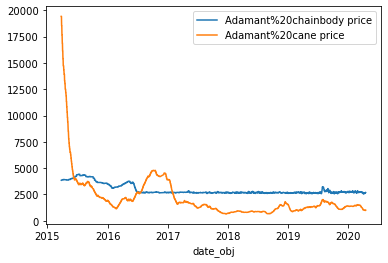

In [269]:
df_21.plot()

In [245]:
list(item_dfs[2].index)

[datetime.date(2015, 3, 26),
 datetime.date(2015, 3, 27),
 datetime.date(2015, 3, 28),
 datetime.date(2015, 3, 29),
 datetime.date(2015, 3, 30),
 datetime.date(2015, 3, 31),
 datetime.date(2015, 4, 1),
 datetime.date(2015, 4, 2),
 datetime.date(2015, 4, 3),
 datetime.date(2015, 4, 4),
 datetime.date(2015, 4, 5),
 datetime.date(2015, 4, 6),
 datetime.date(2015, 4, 7),
 datetime.date(2015, 4, 8),
 datetime.date(2015, 4, 9),
 datetime.date(2015, 4, 10),
 datetime.date(2015, 4, 11),
 datetime.date(2015, 4, 12),
 datetime.date(2015, 4, 13),
 datetime.date(2015, 4, 14),
 datetime.date(2015, 4, 15),
 datetime.date(2015, 4, 16),
 datetime.date(2015, 4, 17),
 datetime.date(2015, 4, 18),
 datetime.date(2015, 4, 19),
 datetime.date(2015, 4, 20),
 datetime.date(2015, 4, 21),
 datetime.date(2015, 4, 22),
 datetime.date(2015, 4, 23),
 datetime.date(2015, 4, 24),
 datetime.date(2015, 4, 25),
 datetime.date(2015, 4, 26),
 datetime.date(2015, 4, 27),
 datetime.date(2015, 4, 28),
 datetime.date(2015, 4,

In [220]:
pd.concat(item_dfs, axis=1)

ValueError: Shape of passed values is (1796, 5), indices imply (1793, 5)

In [170]:
item_df.head()

,dt,price,date_obj
0,1427414400,8135122,2015-03-26
1,1427500800,8135122,2015-03-27
2,1427587200,8135122,2015-03-28
3,1427673600,8135122,2015-03-29
4,1427760000,8135122,2015-03-30


In [32]:
resp = requests.get(full_url)

In [85]:
resp.content

b'{"batchcomplete":"","query":{"pages":{"60167":{"pageid":60167,"ns":828,"title":"Module:Exchange/3rd age amulet/Data","revisions":[{"contentformat":"text/plain","contentmodel":"Scribunto","*":"return {\\n    \'1427414400:8135122\',\\n    \'1427500800:8135122\',\\n    \'1427587200:8135122\',\\n    \'1427673600:8135122\',\\n    \'1427760000:8135122\',\\n    \'1427846400:8135122\',\\n    \'1427932800:8285348\',\\n    \'1428019200:8285348\',\\n    \'1428105600:8285348\',\\n    \'1428192000:8285348\',\\n    \'1428278400:8285348\',\\n    \'1428364800:8285348\',\\n    \'1428451200:8285348\',\\n    \'1428537600:7874506\',\\n    \'1428624000:7874506\',\\n    \'1428710400:7874506\',\\n    \'1428796800:7874506\',\\n    \'1428883200:7874506\',\\n    \'1428969600:7874506\',\\n    \'1429056000:7874506\',\\n    \'1429142400:7512184\',\\n    \'1429228800:7512184\',\\n    \'1429315200:7512184\',\\n    \'1429401600:7512184\',\\n    \'1429488000:7512184\',\\n    \'1429574400:7512184\',\\n    \'142966080

In [38]:
jsond = resp.json()

In [91]:
jsond['query']['pages'][next(iter(jsond['query']['pages'].keys()))]['revisions'][0]['*'].replace('\n','').replace(',    ', ',')

"return {    '1427414400:8135122','1427500800:8135122','1427587200:8135122','1427673600:8135122','1427760000:8135122','1427846400:8135122','1427932800:8285348','1428019200:8285348','1428105600:8285348','1428192000:8285348','1428278400:8285348','1428364800:8285348','1428451200:8285348','1428537600:7874506','1428624000:7874506','1428710400:7874506','1428796800:7874506','1428883200:7874506','1428969600:7874506','1429056000:7874506','1429142400:7512184','1429228800:7512184','1429315200:7512184','1429401600:7512184','1429488000:7512184','1429574400:7512184','1429660800:7512184','1429747200:7187299','1429833600:7187299','1429920000:7187299','1430006400:7187299','1430092800:7187299','1430179200:7057030','1430265600:7057030','1430352000:7057030','1430438400:7057030','1430524800:7057030','1430611200:7057030','1430697600:7057030','1430784000:7310447','1430870400:7310447','1430956800:7310447','1431043200:7310447','1431129600:7310447','1431216000:7310447','1431302400:7310447','1431388800:7310447',

In [94]:
regex_text = jsond['query']['pages'][next(iter(jsond['query']['pages'].keys()))]['revisions'][0]['*']

In [137]:
m = re.findall(r'[\d]+:[\d]+', regex_text)

In [138]:
item_df = pd.DataFrame()

In [139]:
m

['1427414400:8135122',
 '1427500800:8135122',
 '1427587200:8135122',
 '1427673600:8135122',
 '1427760000:8135122',
 '1427846400:8135122',
 '1427932800:8285348',
 '1428019200:8285348',
 '1428105600:8285348',
 '1428192000:8285348',
 '1428278400:8285348',
 '1428364800:8285348',
 '1428451200:8285348',
 '1428537600:7874506',
 '1428624000:7874506',
 '1428710400:7874506',
 '1428796800:7874506',
 '1428883200:7874506',
 '1428969600:7874506',
 '1429056000:7874506',
 '1429142400:7512184',
 '1429228800:7512184',
 '1429315200:7512184',
 '1429401600:7512184',
 '1429488000:7512184',
 '1429574400:7512184',
 '1429660800:7512184',
 '1429747200:7187299',
 '1429833600:7187299',
 '1429920000:7187299',
 '1430006400:7187299',
 '1430092800:7187299',
 '1430179200:7057030',
 '1430265600:7057030',
 '1430352000:7057030',
 '1430438400:7057030',
 '1430524800:7057030',
 '1430611200:7057030',
 '1430697600:7057030',
 '1430784000:7310447',
 '1430870400:7310447',
 '1430956800:7310447',
 '1431043200:7310447',
 '143112960

In [143]:
item_df.head()

,dt,price
0,1427414400,8135122
1,1427500800,8135122
2,1427587200,8135122
3,1427673600,8135122
4,1427760000,8135122


In [150]:
pd.to_datetime(item_df['dt']*1000000)

0      1970-01-17 12:30:14.400
1      1970-01-17 12:31:40.800
2      1970-01-17 12:33:07.200
3      1970-01-17 12:34:33.600
4      1970-01-17 12:36:00.000
                 ...          
1793   1970-01-19 08:44:09.600
1794   1970-01-19 08:45:36.000
1795   1970-01-19 08:47:02.400
1796   1970-01-19 08:48:28.800
1797   1970-01-19 08:49:55.200
Name: dt, Length: 1798, dtype: datetime64[ns]

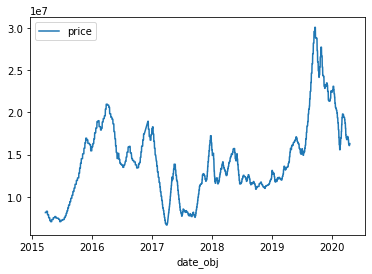

In [161]:
item_df.plot(x='date_obj', y='price')

In [159]:
date.fromtimestamp(item_df['dt'][1797])

datetime.date(2020, 4, 15)